# Layer&Visualization
**Layer들의 종류와 해당 Layer들의 Weight를 시각화**
- 간단하게 몇 가지 Layer만 시도
- 실제 Weight를 시각화해서 생김서 확인하기

In [18]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

%matplotlib inline

## Filtering

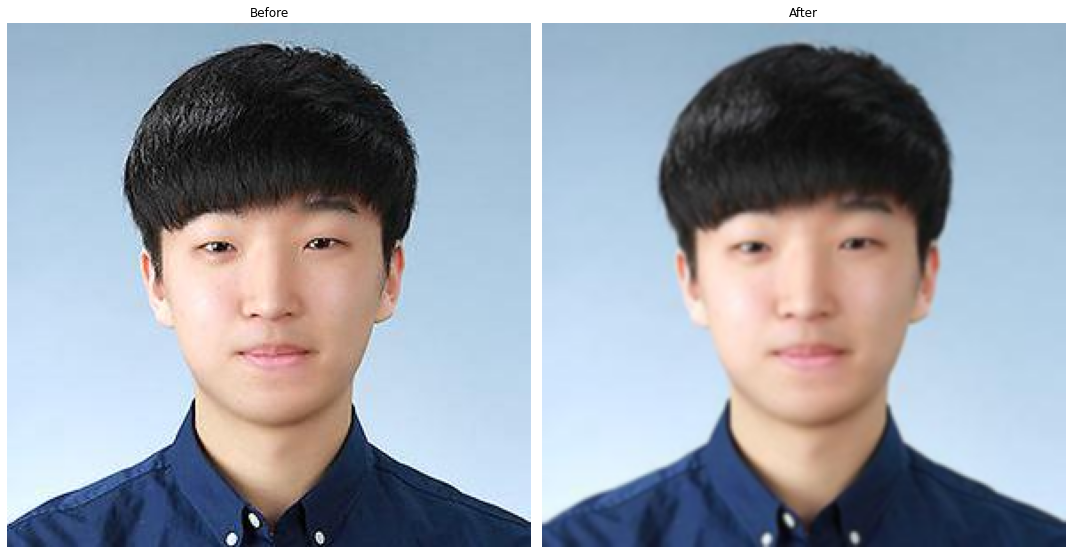

In [61]:
img = cv2.imread('../data/example.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image_blur = cv2.GaussianBlur(img, ksize=(5,5), sigmaX=0)

fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Before')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_blur)
plt.title('After')
plt.axis('off')

plt.tight_layout()

plt.savefig("bulr.jpg", bbox_inches='tight')

## PreProcessing

In [10]:
transform = transforms.Compose([
    transforms.ToTensor()
])

datasets = torchvision.datasets.MNIST('data/', train = True,
                                      download = True, transform = transform)

dataloader = torch.utils.data.DataLoader(datasets, batch_size = 1)

In [12]:
image, label = next(iter(dataloader))
print(image.shape) # Pytorch의 데이터는 batch_size x channel x H x W 로 표시
print(label.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1])


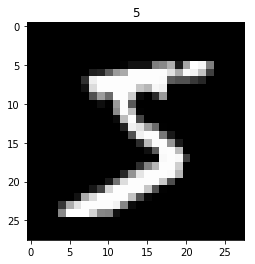

In [25]:
# Visualization
image_squ = torch.squeeze(image)
image_arr = image_squ.numpy()
plt.figure()
plt.title(label.item())
plt.imshow(image_arr, cmap = 'gray')

# Convolution Layer
- CNN의 대표 Layer인 합성곱 레이어 시각화
- Pooling, Linear, Softmax도 시각화

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 1. Conv2d

In [31]:
con_layer = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)
con_layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [35]:
con_weight = con_layer.weight
con_weight.shape # out_channel 20, filter_channel = 1, filter_size = 5x5

torch.Size([20, 1, 5, 5])

- 위에서 출력한 weight는 학습이 가능한 상태이기 때문에 추출이 불가능하다.(gradient)
- 따라서 gradient 기능을 끄고 추출하기 위해 detach()함수를 사용

In [42]:
weight_example = con_weight.detach().numpy()
weight_example.shape

(20, 1, 5, 5)

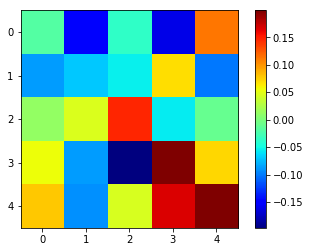

In [46]:
plt.imshow(weight_example[0,0,:,:], cmap = 'jet')
plt.colorbar()

- **Input, Weight, Output Image를 출력하기**

In [58]:
output = con_layer(image)
output_arr = output.detach().numpy() # output도 gradient가 있기 때문에 detach() 사용
image_arr.shape, weight_example.shape, output_arr.shape

((28, 28), (20, 1, 5, 5), (1, 20, 24, 24))

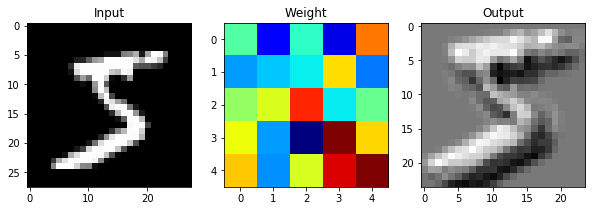

In [62]:
# Visualization
plt.figure(figsize = (10, 15))
plt.subplot(131)
plt.title('Input')
plt.imshow(image_arr, 'gray')

plt.subplot(132)
plt.title('Weight')
plt.imshow(weight_example[0,0,:,:], 'jet')

plt.subplot(133)
plt.title('Output')
plt.imshow(output_arr[0,0,:,:], 'gray')

### 2. Pooling
- 큰 특징을 추출해주는 Layer
- 아래 예시의 경우 2x2 필터를 사용해 이미지의 크기를 1/2 줄여줌

In [71]:
pool_layer = F.max_pool2d(image,2,2)
print('Before Shape : ', image.shape)
print('After Shape : ', pool_layer.shape)

Before Shape :  torch.Size([1, 1, 28, 28])
After Shape :  torch.Size([1, 1, 14, 14])


Text(0.5,1,'Pool Result(14x14)')

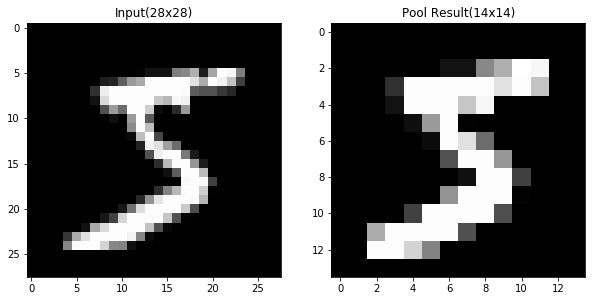

In [77]:
pool_arr = torch.squeeze(pool_layer).numpy() # Pool Layer의 경우 Weight가 없기 때문에 바로 numpy() 가능

plt.figure(figsize = (10, 15))

plt.subplot(121)
plt.imshow(image_arr, 'gray')
plt.title('Input(28x28)')

plt.subplot(122)
plt.imshow(pool_arr, 'gray')
plt.title('Pool Result(14x14)')

### 3. Linear
- 기본으로 사용될 layer
- Linear의 경우 2d가 아닌 1d이기 때문에 reshape 필요(or view)
- 아래 예시의 경우 view()함수를 이용

In [85]:
lin_layer = nn.Linear(28*28, 10) # input_size, output_size
lin_layer

Linear(in_features=784, out_features=10, bias=True)

In [93]:
image_flatten = image.view(-1, 28*28) # 열을 28x28로 만들고 나머지를 행으로 만들어라(-1)
lin_output = lin_layer(image_flatten)
print(lin_output)
print(lin_output.shape)

tensor([[ 0.2891,  0.3113,  0.2044, -0.0863,  0.3559,  0.2755,  0.2509,  0.2539,
          0.2906, -0.0995]], grad_fn=<AddmmBackward>)
torch.Size([1, 10])


Text(0.5,1,'Linear Result(1x10)')

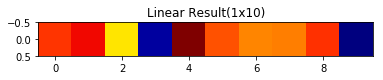

In [97]:
plt.imshow(lin_output.detach().numpy(), 'jet')
plt.title('Linear Result(1x10)')

### 4. Softmax
- 출력층에 사용되는 Layer
- 모델을 통과한 값이 출력층을 통과할 때 '확률'로 해석하기 위해 사용
- 0~1사이의 확률값으로 변환
- 아래 예시에서는 detach()를 사용 안 하고 다른 방법을 이용
- 고것은 바로 with torch.no_grad()

In [108]:
with torch.no_grad():
    image_flatten = image.view(-1, 28*28)
    lin_layer = nn.Linear(28*28, 10)
    image_output = lin_layer(image_flatten)
    softmax_output = F.softmax(image_output, dim = 1)

print(softmax_output.numpy())
print(np.sum(softmax_output.numpy()))


[[0.08616786 0.10344535 0.10251994 0.07755536 0.08927495 0.12112636
  0.09921862 0.13336751 0.11068985 0.07663416]]
1.0
